## "Nombre de mots communs entre personnages (tous les mots)

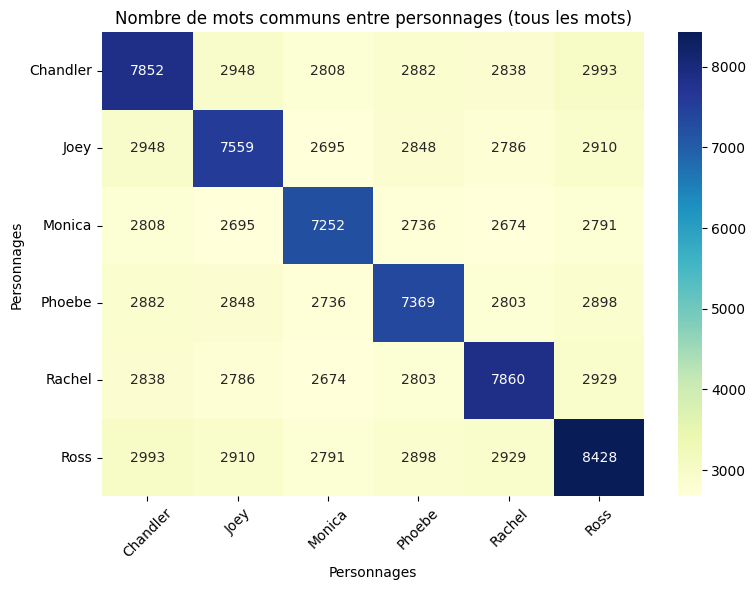

In [14]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# === CHARGEMENT DES DONNÉES ===

# Charger les dialogues
df = pd.read_csv("friends_dialogues_final.csv", encoding="utf-8")

# Personnages principaux
main_characters = ['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross']

# Filtrer uniquement les personnages principaux
df = df[df["character"].isin(main_characters)]

# === STOPWORDS ===

# Charger les stopwords avancés
with open("advanced_stopwords.txt", encoding="latin-1") as f:
    stopwords_set = set(f.read().split("\n"))

# Ajouter des mots spécifiques à ignorer
stopwords_set.update({
    'chandler', 'joey', 'monica', 'phoebe', 'rachel', 'ross',
    'hey', 'gonna', 'wanna', 'um', 'yknow', 'uh', 'umm', 'yeah',
    'ii', 'huh', 'ooh', 'guys'
})

# Fonction de nettoyage d’une ligne de dialogue
def clean_line(text):
    words = re.sub(r"[^\w\s]", "", str(text).lower()).split()
    return [word for word in words if word not in stopwords_set]

# Appliquer le nettoyage
df["tokens"] = df["line"].apply(clean_line)

# === EXTRACTION DES MOTS PAR PERSONNAGE ===

character_words = {}

for character in main_characters:
    tokens = df[df["character"] == character]["tokens"].explode()
    character_words[character] = set(tokens)

# === MATRICE DE SIMILARITÉ ===

characters_sorted = sorted(character_words.keys())
similarity_matrix = pd.DataFrame(index=characters_sorted, columns=characters_sorted)

for c1 in characters_sorted:
    for c2 in characters_sorted:
        common_words = character_words[c1].intersection(character_words[c2])
        similarity_matrix.loc[c1, c2] = len(common_words)

similarity_matrix = similarity_matrix.astype(int)

# === AFFICHAGE DE LA HEATMAP ===

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Nombre de mots communs entre personnages (tous les mots)")
plt.xlabel("Personnages")
plt.ylabel("Personnages")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## tous les mots les plus frequents par chandler et joey

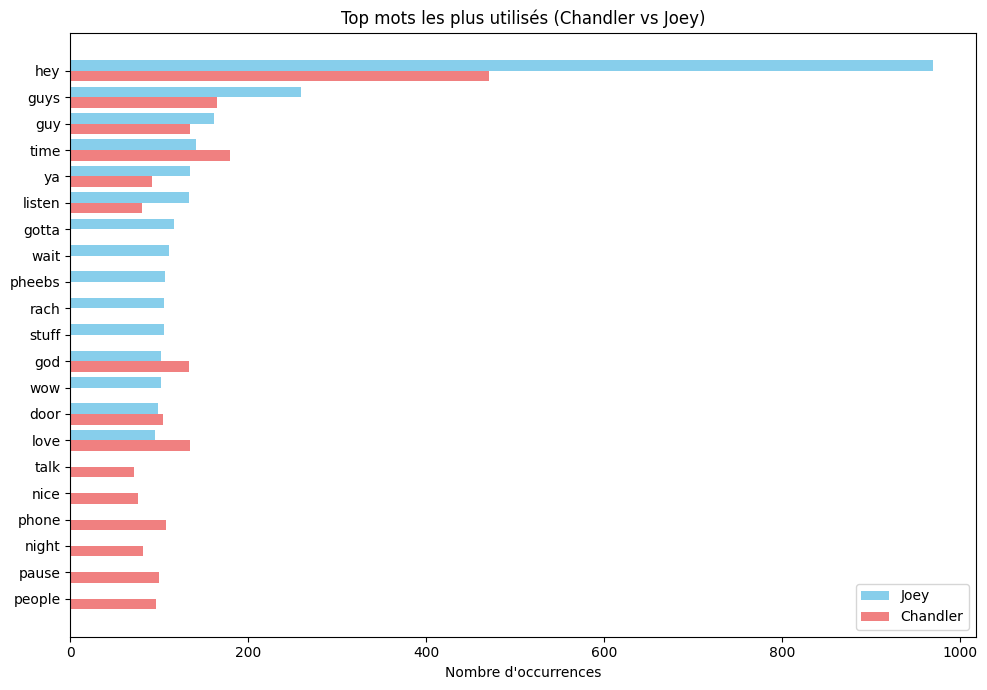

In [15]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# === 1. Chargement des dialogues ===
df = pd.read_csv("friends_dialogues_final.csv", encoding="utf-8")

# === 2. Chargement des stopwords ===
with open("advanced_stopwords.txt", encoding="latin-1") as f:
    stopwords = set(f.read().splitlines())

# Mots à ignorer en plus
stopwords.update({
    'chandler', 'joey', 'monica', 'phoebe', 'rachel', 'ross',
    'yeah', 'uh', 'um', 'huh', 'gonna', 'wanna', 'yknow','entering','starts'
})

# Nettoyage
def clean_line(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return [word for word in text.split() if word not in stopwords]

df["tokens"] = df["line"].apply(clean_line)

# === 3. Fonction pour extraire les mots les plus fréquents d'un personnage ===
def get_top_words(character, top_n=15):
    tokens = [token for row in df[df["character"] == character]["tokens"] for token in row]
    counter = Counter(tokens)
    return counter.most_common(top_n)

# === 4. Appliquer pour Chandler et Joey ===
top_chandler = get_top_words("Chandler")
top_joey = get_top_words("Joey")

# Fusionner les mots dans un tableau unique
words = sorted(set([w for w, _ in top_chandler] + [w for w, _ in top_joey]))
data = []

for word in words:
    chandler_freq = dict(top_chandler).get(word, 0)
    joey_freq = dict(top_joey).get(word, 0)
    data.append({"Word": word, "Chandler": chandler_freq, "Joey": joey_freq})

df_words = pd.DataFrame(data).sort_values(by="Joey", ascending=True)

# === 5. Affichage en image (barres comparatives) ===
fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.4
y = range(len(df_words))

plt.barh([i + bar_width for i in y], df_words["Joey"], height=bar_width, label="Joey", color="skyblue")
plt.barh(y, df_words["Chandler"], height=bar_width, label="Chandler", color="lightcoral")

plt.yticks([i + bar_width / 2 for i in y], df_words["Word"])
plt.xlabel("Nombre d'occurrences")
plt.title("Top mots les plus utilisés (Chandler vs Joey)")
plt.legend()
plt.tight_layout()
plt.savefig("top_words_chandler_joey.png")
plt.show()


## Ross ET RACHEL

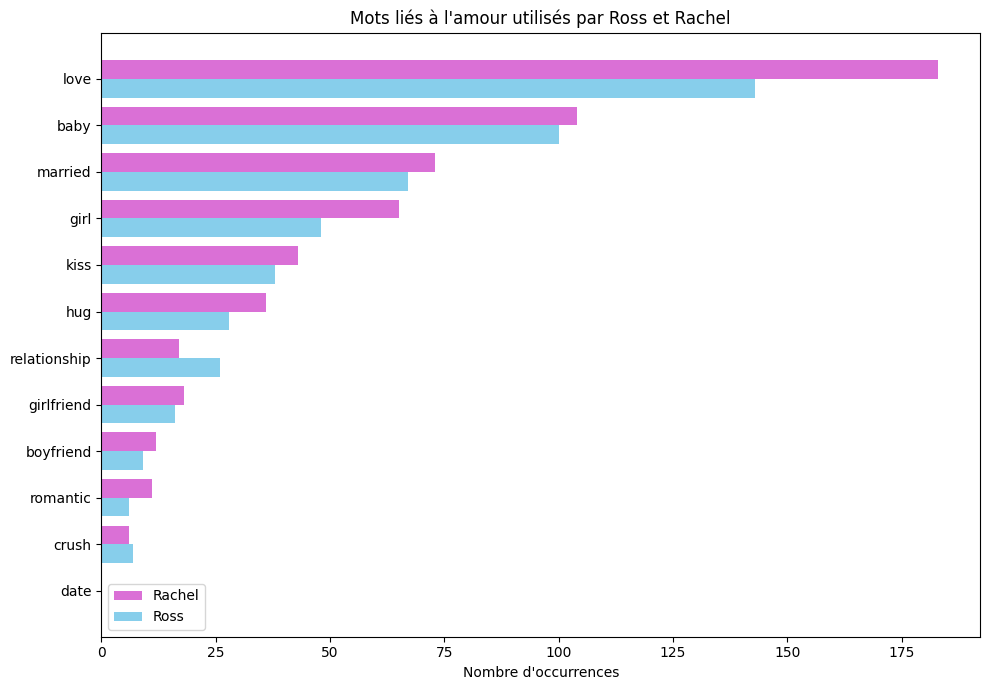

In [12]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# === 1. Chargement des dialogues ===
df = pd.read_csv("friends_dialogues_final.csv", encoding="utf-8")

# === 2. Chargement des stopwords ===
with open("advanced_stopwords.txt", encoding="latin-1") as f:
    stopwords = set(f.read().splitlines())

stopwords.update({
    'chandler', 'joey', 'monica', 'phoebe', 'rachel', 'ross',
    'yeah', 'uh', 'um', 'huh', 'gonna', 'wanna', 'yknow'
})

# === 3. Nettoyage des dialogues ===
def clean_line(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return [word for word in text.split() if word not in stopwords]

df["tokens"] = df["line"].apply(clean_line)

# === 4. Champ lexical de l'amour ===
love_words = {
    "love", "kiss", "hug", "date", "romantic", "baby", "crush",
    "girl", "boyfriend", "girlfriend", "relationship", "married"
}

# === 5. Fonction pour compter les mots d’amour par personnage ===
def count_love_words(character):
    tokens = [token for row in df[df["character"] == character]["tokens"] for token in row]
    counter = Counter(tokens)
    return {word: counter[word] for word in love_words if word in counter}

ross_counts = count_love_words("Ross")
rachel_counts = count_love_words("Rachel")

# === 6. Fusion des données dans un DataFrame ===
data = []
for word in sorted(love_words):
    ross = ross_counts.get(word, 0)
    rachel = rachel_counts.get(word, 0)
    total = ross + rachel
    data.append({"Word": word, "Ross": ross, "Rachel": rachel, "Total": total})

df_love = pd.DataFrame(data).sort_values(by="Total", ascending=True)

# === 7. Affichage sous forme de graphique comparatif ===
fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.4
y = range(len(df_love))

plt.barh([i + bar_width for i in y], df_love["Rachel"], height=bar_width, label="Rachel", color="orchid")
plt.barh(y, df_love["Ross"], height=bar_width, label="Ross", color="skyblue")

plt.yticks([i + bar_width / 2 for i in y], df_love["Word"])
plt.xlabel("Nombre d'occurrences")
plt.title("Mots liés à l'amour utilisés par Ross et Rachel")
plt.legend()
plt.tight_layout()
plt.savefig("amour_ross_rachel.png")
plt.show()


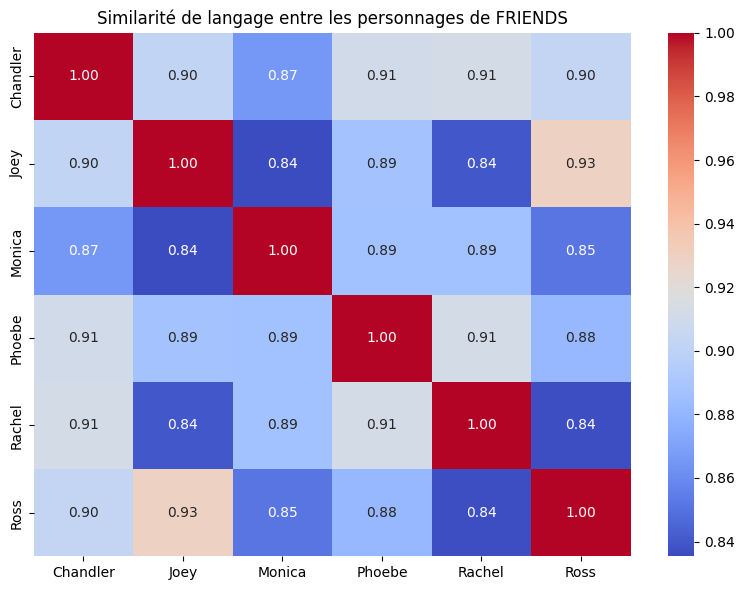

In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Chargement des données ===
df = pd.read_csv("friends_dialogues_final.csv", encoding="utf-8")

# === 2. Chargement des stopwords ===
with open("advanced_stopwords.txt", encoding="latin-1") as f:
    stopwords = set(f.read().splitlines())

# === 3. Nettoyage des dialogues ===
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Enlève ponctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(tokens)

df['clean_line'] = df['line'].apply(clean_text)

# === 4. Filtrage des 6 personnages principaux ===
main_chars = ['Rachel', 'Monica', 'Phoebe', 'Ross', 'Chandler', 'Joey']
df_main = df[df['character'].isin(main_chars)]

# === 5. Regrouper les dialogues par personnage ===
grouped_lines = df_main.groupby('character')['clean_line'].apply(lambda x: ' '.join(x))

# === 6. Vectorisation (bag of words) ===
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(grouped_lines)

# === 7. Calcul de similarité cosinus entre personnages ===
similarity_matrix = cosine_similarity(X)

# === 8. Création de la heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix,
            xticklabels=grouped_lines.index,
            yticklabels=grouped_lines.index,
            annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Similarité de langage entre les personnages de FRIENDS")
plt.tight_layout()
plt.show()


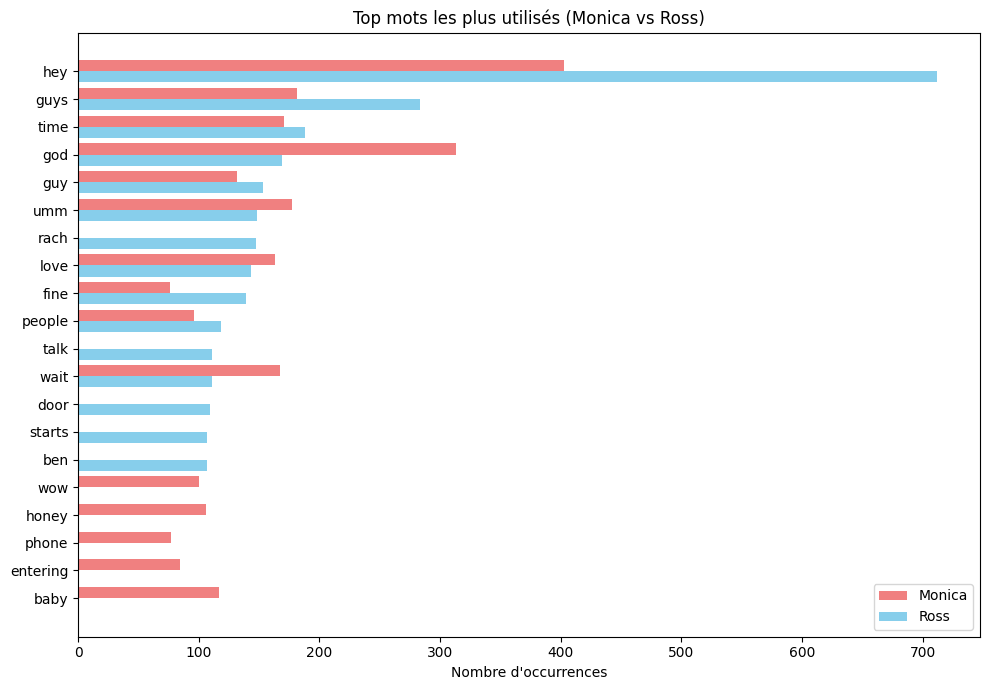

In [13]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# === 1. Chargement des dialogues ===
df = pd.read_csv("friends_dialogues_final.csv", encoding="utf-8")

# === 2. Chargement des stopwords ===
with open("advanced_stopwords.txt", encoding="latin-1") as f:
    stopwords = set(f.read().splitlines())

stopwords.update({
    'chandler', 'joey', 'monica', 'phoebe', 'rachel', 'ross',
    'yeah', 'uh', 'um', 'huh', 'gonna', 'wanna', 'yknow'
})

# === 3. Nettoyage des lignes ===
def clean_line(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return [word for word in text.split() if word not in stopwords]

df["tokens"] = df["line"].apply(clean_line)

# === 4. Fonction pour obtenir les mots les plus fréquents ===
def get_top_words(character, top_n=15):
    tokens = [token for row in df[df["character"] == character]["tokens"] for token in row]
    counter = Counter(tokens)
    return counter.most_common(top_n)

# === 5. Appliquer pour Monica et Ross ===
top_monica = get_top_words("Monica")
top_ross = get_top_words("Ross")

# === 6. Fusion des mots dans un seul tableau ===
words = sorted(set([w for w, _ in top_monica] + [w for w, _ in top_ross]))
data = []

for word in words:
    monica_freq = dict(top_monica).get(word, 0)
    ross_freq = dict(top_ross).get(word, 0)
    data.append({"Word": word, "Monica": monica_freq, "Ross": ross_freq})

df_words = pd.DataFrame(data).sort_values(by="Ross", ascending=True)

# === 7. Affichage en barres horizontales ===
fig, ax = plt.subplots(figsize=(10, 7))
bar_width = 0.4
y = range(len(df_words))

plt.barh([i + bar_width for i in y], df_words["Monica"], height=bar_width, label="Monica", color="lightcoral")
plt.barh(y, df_words["Ross"], height=bar_width, label="Ross", color="skyblue")

plt.yticks([i + bar_width / 2 for i in y], df_words["Word"])
plt.xlabel("Nombre d'occurrences")
plt.title("Top mots les plus utilisés (Monica vs Ross)")
plt.legend()
plt.tight_layout()
plt.savefig("top_words_monica_ross.png")
plt.show()
